In [1]:
%precision 3
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg as sl
import scipy.sparse as sp
import scipy.sparse.linalg as spla
# the following allows us to plot triangles indicating convergence order
from matplotlib import cm
# and we will create some animations!
import matplotlib.animation as animation
from IPython.display import HTML
from pprint import pprint

In [2]:
def pressure_poisson_jacobi(p, dx, dy, RHS, rtol = 1.e-5, logs = False):
    """ Solve the pressure Poisson equation (PPE)
    using Jacobi iteration assuming mesh spacing of
    dx and dy (we assume at the moment that dx=dy)
    and the RHS function given by RHS.
    
    Assumes imposition of a Neumann BC on all boundaries.
    
    Return the pressure field.
    """
    # iterate
    tol = 10.*rtol
    it = 0
    p_old = np.copy(p)
    imax = len(p)
    jmax = np.size(p)//imax
    while tol > rtol:
        it += 1
        
        #swap arrays without copying the data
        temp = p_old
        p_old = p
        p = temp
        
        #this version is valid for dx!=dy
        p[1:-1, 1:-1] = 1.0/(2.0+2.0*(dx**2)/(dy**2))*(p_old[2:, 1:-1] + p_old[:-2, 1:-1] +
                                (p_old[1:-1, 2:] + p_old[1:-1,:-2])*(dx**2)/(dy**2)
                                - (dx**2)*RHS[1:-1, 1:-1])
        
        # apply zero gradient Neumann boundary conditions at the no slip walls
        p[-1, :] = p[-2, :] #right
        p[:, 0] = p[:, 1] #bottom
        p[:-(imax-imax//2) + 1, -1] = p[:-(imax-imax//2) + 1, -2] #top

        # relative change in pressure
        tol = sl.norm(p - p_old)/np.maximum(1.0e-10,sl.norm(p))
        
    if logs: print('pressure solve iterations = {:4d}'.format(it))
    return p

In [3]:
def calculate_ppm_RHS_upwind(rho, u, v, RHS, dt, dx, dy):
    """ Calculate the RHS of the 
    Poisson equation resulting from the projection method.
    Use upwind differences for the first derivatives of u and v.
    """
    RHS[1:-1, 1:-1] =rho*(np.select([u[1:-1, 1:-1] > 0, u[1:-1, 1:-1] < 0],
                      [np.diff(u[:-1, 1:-1], n=1, axis=0)/dx,
                       np.diff(u[1:, 1:-1], n=1, axis=0)/dx]) + 
              np.select([v[1:-1, 1:-1] > 0, v[1:-1, 1:-1] < 0],
                      [np.diff(v[1:-1, :-1], n=1, axis=1)/dy,
                       np.diff(v[1:-1, 1:], n=1, axis=1)/dy]))
    return RHS

def calculate_ppm_RHS_central(rho, u, v, RHS, dt, dx, dy):
    """ Calculate the RHS of the 
    Poisson equation resulting from the projection method.
    Use central differences for the first derivatives of u and v.
    """
    RHS[1:-1, 1:-1] = rho * (
        (1.0/dt) * ( (u[2:, 1:-1] - u[:-2, 1:-1]) / (2*dx) 
                   + (v[1:-1, 2:] - v[1:-1, :-2]) / (2*dy) ))
    return RHS

def project_velocity(rho, u, v, dt, dx, dy, p):
    """ Update the velocity to be divergence free using the pressure.
    """
    u[1:-1, 1:-1] = u[1:-1, 1:-1] - dt * (1./rho) * (
        (p[2:, 1:-1] - p[:-2, 1:-1])/(2*dx) )
    v[1:-1, 1:-1] = v[1:-1, 1:-1] - dt * (1./rho) * (
        (p[1:-1, 2:] - p[1:-1, :-2])/(2*dy) )
    
    #apply the velocity boundary condition to the projected velocity data
    imax = len(u)
    jmax = np.size(u)//imax
    u[0,:] = u[1,:]
    v[imax//2:,-1] = v[imax//2:,-2]
    
    
    return u, v

def calculate_intermediate_velocity(nu, u, v, u_old, v_old, dt, dx, dy):
    """ Calculate the intermediate velocities.
    """
    # intermediate u
    u[1:-1, 1:-1] = u_old[1:-1, 1:-1] - dt * (
                      # ADVECTION:  uu_x + vu_x
                        u_old[1:-1, 1:-1] *
                      # see comments in the upwind based solver for advection above
                      np.select([u_old[1:-1, 1:-1] > 0, u_old[1:-1, 1:-1] < 0],
                      [np.diff(u_old[:-1, 1:-1], n=1, axis=0)/dx,
                       np.diff(u_old[1:, 1:-1], n=1, axis=0)/dx]) +
                             v_old[1:-1, 1:-1] *
                       np.select([v_old[1:-1, 1:-1] > 0, v_old[1:-1, 1:-1] < 0],
                      [np.diff(u_old[1:-1, :-1], n=1, axis=1)/dy,
                       np.diff(u_old[1:-1, 1:], n=1, axis=1)/dy]) ) + (
                       # DIFFUSION
                         dt*nu*(np.diff(u_old[:, 1:-1], n=2, axis=0)/(dx**2)
                                 + np.diff(u_old[1:-1, :], n=2, axis=1)/(dy**2)) )
    # intermediate v
    v[1:-1, 1:-1] = v_old[1:-1, 1:-1] - dt * (
                      # ADVECTION:  uv_x + vv_x
                        u_old[1:-1, 1:-1] *
                      np.select([u_old[1:-1, 1:-1] > 0, u_old[1:-1, 1:-1] < 0],
                      [np.diff(v_old[:-1, 1:-1], n=1, axis=0)/dx,
                       np.diff(v_old[1:, 1:-1], n=1, axis=0)/dx]) +
                             v_old[1:-1, 1:-1] *
                       np.select([v_old[1:-1, 1:-1] > 0, v_old[1:-1, 1:-1] < 0],
                      [np.diff(v_old[1:-1, :-1], n=1, axis=1)/dy,
                       np.diff(v_old[1:-1, 1:], n=1, axis=1)/dy]) ) + (
                       # DIFFUSION
                        dt*nu*(np.diff(v_old[:, 1:-1], n=2, axis=0)/(dx**2)
                                 + np.diff(v_old[1:-1, :], n=2, axis=1)/(dy**2)) )
    
    return u, v

In [5]:
def solve_NS(u, v, p, rho, nu, courant, dt_min, t_end, dx, dy, rtol = 1.e-5, logs = False, outint = 100):
    """ Solve the incompressible Navier-Stokes equations
    using a lot of the numerical choices and approaches we've seen
    earlier in this lecture.
    """
    t = 0
    
    u_old = u.copy()
    v_old = v.copy()
    p_RHS = np.zeros_like(X)
    
    time_it = 0 
    temp_stamp = 0
    state_count = 0

    while t < t_end:
        u_status = u.copy()
        v_status = v.copy()
        p_status = p.copy()
        time_it+=1
        #set dt based on courant number
        vel_max = np.max(np.sqrt(u**2+v**2))
        if vel_max>0.0:
            dt = min(courant*min(dx,dy)/vel_max,dt_min)
        else:
            dt = dt_min
            
        t += dt
        if logs and time_it%outint == 0: 
            print('\nTime = {:.8f}'.format(t))
            
        # calculate intermediate velocities
        u, v = calculate_intermediate_velocity(nu, u, v, u_old, v_old, dt, dx, dy)
        # PPM
        # calculate RHS for the pressure Poisson problem
        p_RHS = calculate_ppm_RHS_central(rho, u, v, p_RHS, dt, dx, dy)
        # compute pressure - note that we use the previous p as an initial guess to the solution
        p = pressure_poisson_jacobi(p, dx, dy, p_RHS, 1.e-5, logs = (logs and time_it%outint == 0))
        # project velocity
        u, v = project_velocity(rho, u, v, dt, dx, dy, p)
        
        if logs and time_it%outint == 0:
            print('norm(u) = {0:.8f}, norm(v) = {1:.8f}'.format(sl.norm(u),sl.norm(v)))
            print('Courant number: {0:.8f}'.format(np.max(np.sqrt(u**2+v**2)) * dt / min(dx,dy)))
                
        #swap pointers without copying data
        temp = u_old
        u_old = u
        u = temp
        temp = v_old
        v_old = v
        v = temp
    
        #steady status check
        tol = 1e-8
        dif_u = abs(u - u_status)
        dif_v = abs(v - v_status)
        dif_p = abs(p - p_status)
        if np.all(dif_u < tol) and np.all(dif_v < tol) and np.all(dif_p < tol):
            state_count += 1
        if state_count > 5 and temp_stamp == 0:
            temp_stamp = t
            print("status: steady!")
            
    return u, v, p, (state_count, temp_stamp)

In [ ]:
# physical parameters
rho = 1000.
mu = 0.001
nu = mu / rho

# define spatial mesh
# Size of rectangular domain
Lx = 0.01
Ly = 0.005

P_max = 0.5

# Number of grid points in each direction, including boundary nodes
Nx = 101
Ny = 51

# hence the mesh spacing
dx = Lx/(Nx-1)
dy = Ly/(Ny-1)

# read the docs to see the ordering that mgrid gives us
X, Y = np.mgrid[0:Nx:1, 0:Ny:1]
X = dx*X
Y = dy*Y
# the following is an alternative to the three lines above
#X, Y = np.mgrid[0: Lx + 1e-10: dx, 0: Ly + 1e-10: dy]
# but without the need to add a "small" increement to ensure
# the Lx and Ly end points are included

# initialise independent variables
u = np.zeros_like(X)
v = np.zeros_like(X)
p = np.zeros_like(X)

# Apply Dirichlet BCs to u and v - the code below doesn't touch 
# these so we can do this once outside the time loop
u[:, -1] = 0
u[:, 0] = 0
u[0, :] = 0
u[-1, :] = 0
v[:, -1] = 0
v[:, 0] = 0
v[0, :] = 0
v[-1, :] = 0
imax = len(u)
jmax = np.size(u)//imax

p[0, :] = P_max
p[imax//2:, -1] = 0.0

#set a Courant number and use dynamic time step
courant = 0.005
dt_min = 1.e-3

t_end = 15.0

import time
start = time.time()
u, v, p, (status, time_stamp) = solve_NS(u, v, p, rho, nu, courant, dt_min, t_end, dx, dy, rtol=1.e-6, logs = True, outint = 1000)
end = time.time()
print('Time taken by calculation = ', end - start)
if status > 5:
    print("System achieve steady status at {:.8f}".format(time_stamp))
else:
    print("System did not achieve steady status...")

From the simulation result above, we can see that for the tol threshold is 1e-8, the fluid system would achieve the steady status at time = 3.164.

Then we are going to draw this data into graphes as below:

Text(0.5, 1.0, 'Pressure driven problem - speed')

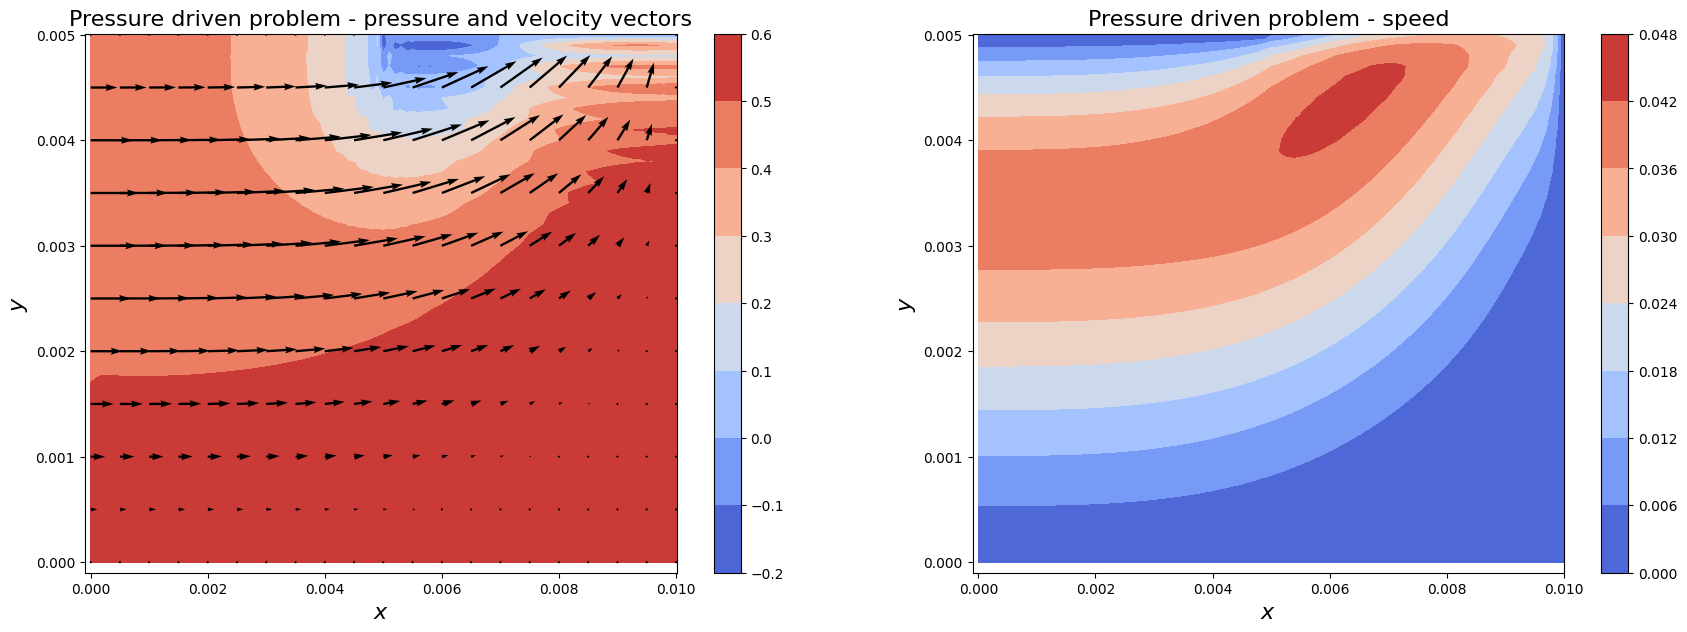

In [7]:
# set up figure
fig = plt.figure(figsize=(21, 7))
ax1 = fig.add_subplot(121)
cont = ax1.contourf(X,Y,p, cmap=cm.coolwarm)
fig.colorbar(cont)
# don't plot at every gird point - every 5th
ax1.quiver(X[::5,::5],Y[::5,::5],u[::5,::5],v[::5,::5])
ax1.set_xlim(-0.0001, 0.01001)
ax1.set_ylim(-0.0001, 0.00501)
ax1.set_xlabel('$x$', fontsize=16)
ax1.set_ylabel('$y$', fontsize=16)
ax1.set_title('Pressure driven problem - pressure and velocity vectors', fontsize=16)

ax1 = fig.add_subplot(122)
cont = ax1.contourf(X,Y,np.sqrt(u*u+v*v), cmap=cm.coolwarm)
fig.colorbar(cont)
ax1.set_xlim(-0.0001, 0.01001)
ax1.set_ylim(-0.0001, 0.00501)
ax1.set_xlabel('$x$', fontsize=16)
ax1.set_ylabel('$y$', fontsize=16)
ax1.set_title('Pressure driven problem - speed', fontsize=16)

In [8]:
flow_in = np.average(u[0,:])*Ly
flow_out = np.average(v[:,-1])*Lx

print('flow in: ',flow_in)
print('flow out: ',flow_out)

flow in:  0.0001133371187887828
flow out:  0.0001135938571355008


For the simulation result, we can see the flow in is almost equals to the flow out as we expected what would happen in the steady status.

<img src="./uploaded_handwriting/2-page1.png">
<img src="./uploaded_handwriting/2-page2.png">

In [4]:
def vectorized_calculate_temperature(T, u, v, k, dt, dx, dy, T_inlet):
    Nx, Ny = T.shape
    T_new = np.copy(T)

    ux = np.maximum(u[1:-1, 1:-1], 0) * (T[1:-1, 1:-1] - T[:-2, 1:-1]) / dx \
         + np.minimum(u[1:-1, 1:-1], 0) * (T[2:, 1:-1] - T[1:-1, 1:-1]) / dx
    uy = np.maximum(v[1:-1, 1:-1], 0) * (T[1:-1, 1:-1] - T[1:-1, :-2]) / dy \
         + np.minimum(v[1:-1, 1:-1], 0) * (T[1:-1, 2:] - T[1:-1, 1:-1]) / dy

    diff_x = (T[2:, 1:-1] - 2 * T[1:-1, 1:-1] + T[:-2, 1:-1]) / dx**2
    diff_y = (T[1:-1, 2:] - 2 * T[1:-1, 1:-1] + T[1:-1, :-2]) / dy**2

    T_new[1:-1, 1:-1] = T[1:-1, 1:-1] - dt * (ux + uy) + k * dt * (diff_x + diff_y)

    T_new[0, :] = T_inlet
    imax = Nx
    T_new[imax//2:, -1] = T_new[imax//2:, -2]

    return T_new


In [5]:
def solve_NS(T, u, v, p, rho, nu, courant, dt_min, t_end, dx, dy, rtol = 1.e-5, logs = False, outint = 100, k = 5e-6, T_inlet = 20):
    """ Solve the incompressible Navier-Stokes equations
    using a lot of the numerical choices and approaches we've seen
    earlier in this lecture.
    """
    t = 0
    
    u_old = u.copy()
    v_old = v.copy()
    p_RHS = np.zeros_like(X)
    
    time_it = 0
    F_state_count = 0
    F_temp_stamp = 0

    T_state_count = 0
    T_temp_stamp = 0
    
    while t < t_end:
        u_status = u.copy()
        v_status = v.copy()
        p_status = p.copy()
        T_status = T.copy()
        time_it+=1
        #set dt based on courant number
        vel_max = np.max(np.sqrt(u**2+v**2))
        if vel_max>0.0:
            dt = min(courant*min(dx,dy)/vel_max,dt_min)
        else:
            dt = dt_min
            
        t += dt
        if logs and time_it%outint == 0: 
            print('\nTime = {:.8f}'.format(t))
            
        # calculate intermediate velocities
        u, v = calculate_intermediate_velocity(nu, u, v, u_old, v_old, dt, dx, dy)

        

        # PPM
        # calculate RHS for the pressure Poisson problem
        p_RHS = calculate_ppm_RHS_central(rho, u, v, p_RHS, dt, dx, dy)
        # compute pressure - note that we use the previous p as an initial guess to the solution
        p = pressure_poisson_jacobi(p, dx, dy, p_RHS, 1.e-5, logs = (logs and time_it%outint == 0))
        # project velocity
        u, v = project_velocity(rho, u, v, dt, dx, dy, p)

        T = vectorized_calculate_temperature(T, u, v, k, dt, dx, dy, T_inlet)

        
        
        if logs and time_it%outint == 0:
            print('norm(u) = {0:.8f}, norm(v) = {1:.8f}'.format(sl.norm(u),sl.norm(v)))
            print('Courant number: {0:.8f}'.format(np.max(np.sqrt(u**2+v**2)) * dt / min(dx,dy)))
                
        #swap pointers without copying data
        temp = u_old
        u_old = u
        u = temp
        temp = v_old
        v_old = v
        v = temp

        #steady status check
        tol = 1e-8
        dif_u = abs(u - u_status)
        dif_v = abs(v - v_status)
        dif_p = abs(p - p_status)
        if np.all(dif_u < tol) and np.all(dif_v < tol) and np.all(dif_p < tol):
            F_state_count += 1
        if F_state_count > 5 and F_temp_stamp == 0:
            F_temp_stamp = t
            print("Fluid status: steady!")

        tol2 = 1e-5
        dif_T = abs(T - T_status)
        if np.all(dif_T < tol2):
            T_state_count += 1
        if T_state_count > 5 and T_temp_stamp == 0:
            T_temp_stamp = t
            print("Temperature status: steady!")
    return u, v, p, T, (F_state_count, F_temp_stamp), (T_state_count, T_temp_stamp)

In [ ]:
# physical parameters
rho = 1000.
mu = 0.001
nu = mu / rho

# define spatial mesh
# Size of rectangular domain
Lx = 0.01
Ly = 0.005

P_max = 0.5

# Number of grid points in each direction, including boundary nodes
Nx = 101
Ny = 51

# hence the mesh spacing
dx = Lx/(Nx-1)
dy = Ly/(Ny-1)

# read the docs to see the ordering that mgrid gives us
X, Y = np.mgrid[0:Nx:1, 0:Ny:1]
X = dx*X
Y = dy*Y
# the following is an alternative to the three lines above
#X, Y = np.mgrid[0: Lx + 1e-10: dx, 0: Ly + 1e-10: dy]
# but without the need to add a "small" increement to ensure
# the Lx and Ly end points are included

# initialise independent variables
u = np.zeros_like(X)
v = np.zeros_like(X)
p = np.zeros_like(X)
T = np.zeros_like(X)



# Apply Dirichlet BCs to u and v - the code below doesn't touch 
# these so we can do this once outside the time loop
u[:, -1] = 0
u[:, 0] = 0
u[0, :] = 0
u[-1, :] = 0
v[:, -1] = 0
v[:, 0] = 0
v[0, :] = 0
v[-1, :] = 0
imax = len(u)
jmax = np.size(u)//imax

p[0, :] = P_max
p[imax//2:, -1] = 0.0

T[-1, :] = 100
T[:imax//2, -1] = 100
T[:, 0] = 100
T[0, :] = 20.0

#set a Courant number and use dynamic time step
courant = 0.005
dt_min = 1.e-4

t_end = 10

import time
start = time.time()
u, v, p, T, (F_state_count, F_temp_stamp), (T_state_count, T_temp_stamp) = solve_NS(T, u, v, p, rho, nu, courant, dt_min, t_end, dx, dy, rtol=1.e-6, logs = True, outint = 1000)
end = time.time()
print('Time taken by calculation = ', end - start)
if F_state_count > 5:
    print("Fluid System achieve steady status at {:.8f}".format(F_temp_stamp))
else:
    print("Fluid System did not achieve steady status...")
if T_state_count > 5:
    print("Temperature System achieve steady status at {:.8f}".format(T_temp_stamp))
else:
    print("Temperature System did not achieve steady status...")

From the simulation above, we see that all fluid system and temperature system achieve steady status. And the temperature system achieve steady status is quicker than fluid system. This may because of the threshold setting of temperature is higher than that of fluid system.

Text(0.5, 1.0, 'Pressure driven problem - Temperature')

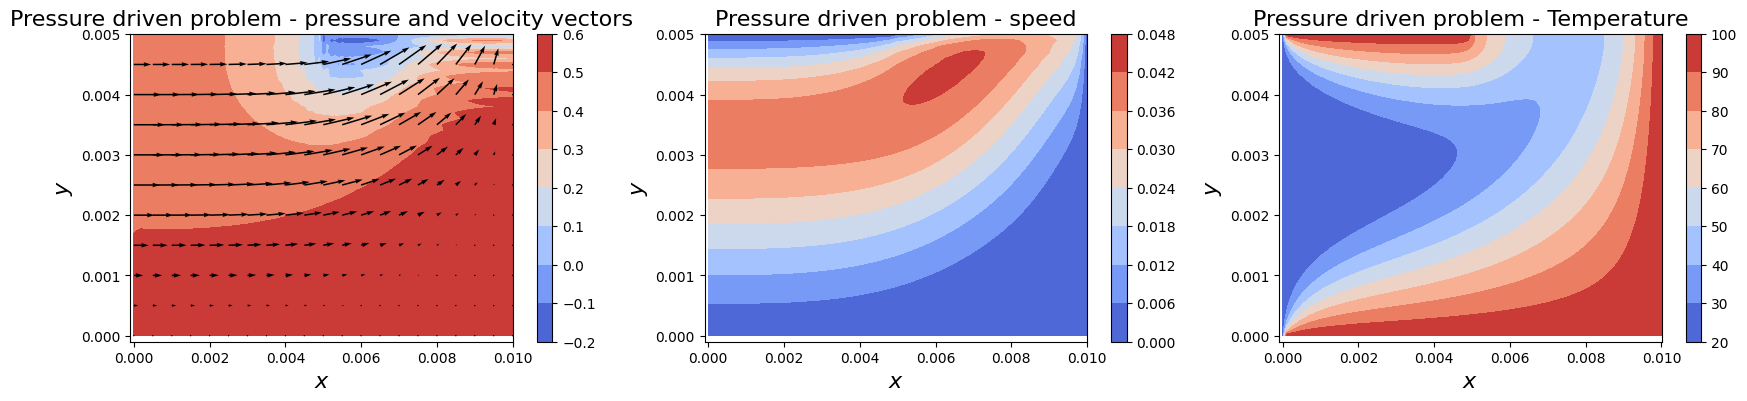

In [12]:
# set up figure
fig = plt.figure(figsize=(21, 4))
ax1 = fig.add_subplot(131)
cont = ax1.contourf(X,Y,p, cmap=cm.coolwarm)
fig.colorbar(cont)
# don't plot at every gird point - every 5th
ax1.quiver(X[::5,::5],Y[::5,::5],u[::5,::5],v[::5,::5])
ax1.set_xlim(-0.0001, 0.01001)
ax1.set_ylim(-0.0001, 0.00501)
ax1.set_xlabel('$x$', fontsize=16)
ax1.set_ylabel('$y$', fontsize=16)
ax1.set_title('Pressure driven problem - pressure and velocity vectors', fontsize=16)

ax1 = fig.add_subplot(132)
cont = ax1.contourf(X,Y,np.sqrt(u*u+v*v), cmap=cm.coolwarm)
fig.colorbar(cont)
ax1.set_xlim(-0.0001, 0.01001)
ax1.set_ylim(-0.0001, 0.00501)
ax1.set_xlabel('$x$', fontsize=16)
ax1.set_ylabel('$y$', fontsize=16)
ax1.set_title('Pressure driven problem - speed', fontsize=16)

ax1 = fig.add_subplot(133)
cont = ax1.contourf(X,Y,T, cmap=cm.coolwarm)
fig.colorbar(cont)
ax1.set_xlim(-0.0001, 0.01001)
ax1.set_ylim(-0.0001, 0.00501)
ax1.set_xlabel('$x$', fontsize=16)
ax1.set_ylabel('$y$', fontsize=16)
ax1.set_title('Pressure driven problem - Temperature', fontsize=16)

In [13]:
flow_in = np.average(u[0,:])*Ly
flow_out = np.average(v[:,-1])*Lx

print('flow in: ',flow_in)
print('flow out: ',flow_out)

flow in:  0.0001133371187898789
flow out:  0.00011359385713654141


In [14]:
temperature_in = np.average(T[0,:])
temperature_out = np.average(T[imax//2:,-1])

print('Average Temperature in: ',temperature_in)
print('Average Temperature out: ',temperature_out)

Average Temperature in:  20.0
Average Temperature out:  59.2814661783235


Calculation of the flow average outflow temperature:

In [15]:
result = T[imax//2:,-1] * v[imax//2:,-1] / np.average(v[imax//2:,-1])
print(np.average(result))

55.620523606214746


As a result, the flow average outflow temperature is 55.6205236.

There are two choice. The first one is to dimensionalize the equations and solve it in dimensionless form, the other one is to keep everything in normal dimensional form but based on the dimensionless versions of the variables when change them.

I choose the second way to do more research on this model. I will keep everything in normal dimensional and use dimensionless groups to do research on them.

To investigate how parameters in this model influence the results, I will analyze it in terms of dimensionless groups. In this fluid dynamics, I will use dimensionless groups Reynolds number and Prandtl number to do further research.

The __Reynolds number__ is a ratio of inertial forces to viscous forces, which is:
$$ Re = \frac{\rho U L}{\mu}$$
$ \rho $ is fluid density, which was set to 1000 in the previous parts as the document suggested.

$ U $ is the characteristic velocity.

$ L $ is the characteristic length.

$ \mu $ is the viscosity of the fluid, which was set to 0.001 in the previous parts as the document suggested.


The __Prandtl Number__ is the ratio of kinematic viscosity to thermal diffusivity, which is:
$$ Pr = \frac{\nu}{k}$$
$ \nu $ is given by $ \mu $ divided by $ \rho $

$ k $ is the thermal diffusivity


First, let implement the code about setting parameter and calculate the Reynolds number and Prandtl Number:

In [30]:
u_input = 0.0001
v_input = 0.
Lx = 0.01
k = 5e-6
rho = 1000.
mu = 0.001
nu = mu / rho

In [31]:
# Define characteristic parameters
U_char = np.max(np.sqrt(u_input**2 + v_input**2))  # Characteristic velocity
L_char = Lx  # Characteristic length, can choose either Lx or Ly
Delta_T = 100 - 20  # Characteristic temperature difference

# Calculate dimensionless groups
Re = rho * U_char * L_char / mu
Pr = nu / k

print(f'Reynolds Number (Re): {Re}')
print(f'Prandtl Number (Pr): {Pr}')


Reynolds Number (Re): 1.0
Prandtl Number (Pr): 0.19999999999999998


In [6]:
def model(u_input, v_input, Lx, k, rho, mu, nu):
    Ly = 0.005
    P_max = 0.5
    Nx = 101
    Ny = 51

    dx = Lx/(Nx-1)
    dy = Ly/(Ny-1)

    X, Y = np.mgrid[0:Nx:1, 0:Ny:1]
    X = dx*X
    Y = dy*Y

    u = np.zeros_like(X)
    v = np.zeros_like(X)
    p = np.zeros_like(X)
    T = np.zeros_like(X)

    u[:, -1] = 0
    u[:, 0] = 0
    u[0, :] = u_input
    u[-1, :] = 0
    v[:, -1] = 0
    v[:, 0] = 0
    v[0, :] = v_input
    v[-1, :] = 0
    imax = len(u)
    jmax = np.size(u)//imax

    p[0, :] = P_max
    p[imax//2:, -1] = 0.0

    T[-1, :] = 100
    T[:imax//2, -1] = 100
    T[:, 0] = 100
    T[0, :] = 20.0

    courant = 0.005
    dt_min = 1.e-4
    t_end = 15

    import time
    start = time.time()
    u, v, p, T, (F_state_count, F_temp_stamp), (T_state_count, T_temp_stamp) = solve_NS(T, u, v, p, rho, nu, courant, dt_min, t_end, dx, dy, rtol=1.e-6, logs = True, k = k, outint = 1000)
    end = time.time()
    print('Time taken by calculation = ', end - start)
    if F_state_count > 5:
        print("Fluid System achieve steady status at {:.8f}".format(F_temp_stamp))
    else:
        print("Fluid System did not achieve steady status...")
    if T_state_count > 5:
        print("Temperature System achieve steady status at {:.8f}".format(T_temp_stamp))
    else:
        print("Temperature System did not achieve steady status...")
    return u, v, p, T

In [13]:
def draw(u, v, p, T):
    # set up figure
    fig = plt.figure(figsize=(21, 4))
    ax1 = fig.add_subplot(131)
    cont = ax1.contourf(X,Y,p, cmap=cm.coolwarm)
    fig.colorbar(cont)
    # don't plot at every gird point - every 5th
    ax1.quiver(X[::5,::5],Y[::5,::5],u[::5,::5],v[::5,::5])
    ax1.set_xlim(-0.0001, 0.01001)
    ax1.set_ylim(-0.0001, 0.00501)
    ax1.set_xlabel('$x$', fontsize=16)
    ax1.set_ylabel('$y$', fontsize=16)
    ax1.set_title('Pressure driven problem - pressure and velocity vectors', fontsize=16)

    ax1 = fig.add_subplot(132)
    cont = ax1.contourf(X,Y,np.sqrt(u*u+v*v), cmap=cm.coolwarm)
    fig.colorbar(cont)
    ax1.set_xlim(-0.0001, 0.01001)
    ax1.set_ylim(-0.0001, 0.00501)
    ax1.set_xlabel('$x$', fontsize=16)
    ax1.set_ylabel('$y$', fontsize=16)
    ax1.set_title('Pressure driven problem - speed', fontsize=16)

    ax1 = fig.add_subplot(133)
    cont = ax1.contourf(X,Y,T, cmap=cm.coolwarm)
    fig.colorbar(cont)
    ax1.set_xlim(-0.0001, 0.01001)
    ax1.set_ylim(-0.0001, 0.00501)
    ax1.set_xlabel('$x$', fontsize=16)
    ax1.set_ylabel('$y$', fontsize=16)
    ax1.set_title('Pressure driven problem - Temperature', fontsize=16)

In [8]:
def cal(u_input, v_input, Lx, k, rho, mu, nu):
    U_char = np.max(np.sqrt(u_input**2 + v_input**2))  # Characteristic velocity
    L_char = Lx  # Characteristic length, can choose either Lx or Ly
    Delta_T = 100 - 20  # Characteristic temperature difference

    # Calculate dimensionless groups
    Re = rho * U_char * L_char / mu
    Pr = nu / k
    return (Re, Pr)

In [ ]:
u, v, p, T = model(u_input, v_input, Lx, k, rho, mu, nu)

## __Series 1 Reynolds Number__

## Occassion for Re = 1:

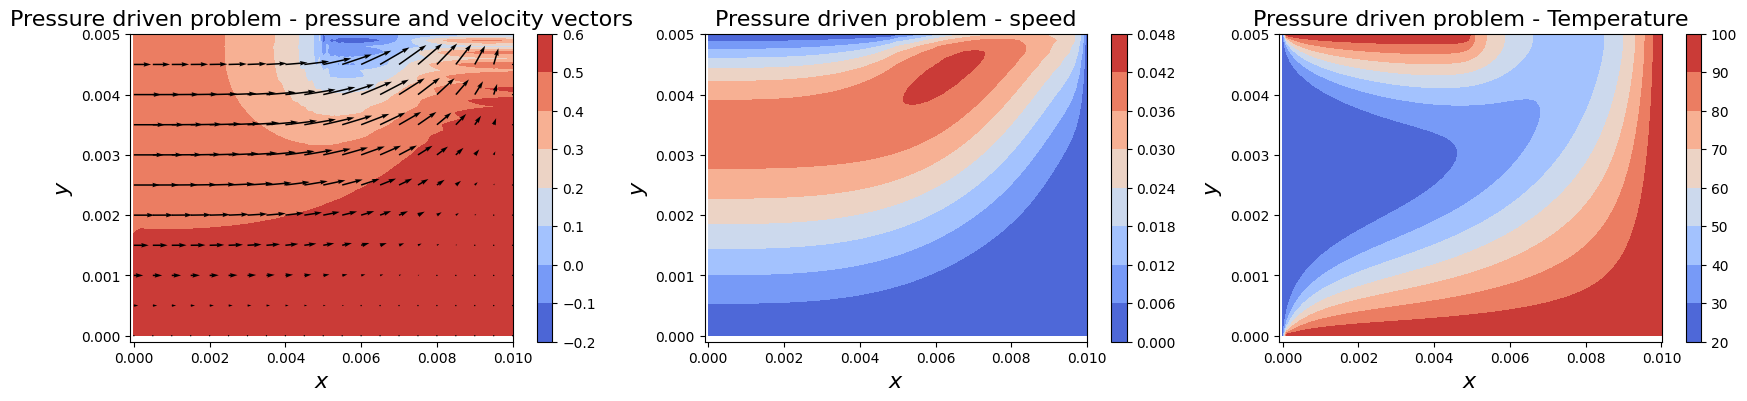

In [37]:
draw(u, v, p, T)

## Occassion for Re = 10:
increase the $ \rho $ to 10 times

In [ ]:
u_input = 0.0001
v_input = 0.
Lx = 0.01
k = 5e-6
rho = 10000.
mu = 0.001
nu = mu / rho
print(cal(u_input, v_input, Lx, k, rho, mu, nu))
u, v, p, T = model(u_input, v_input, Lx, k, rho, mu, nu)
draw(u, v, p, T)



## Occassion for Re = 100:
increase the $ Lx $ to 10 times

In [ ]:
u_input = 0.0001
v_input = 0.
Lx = 0.1
k = 5e-6
rho = 10000.
mu = 0.001
nu = mu / rho
print(cal(u_input, v_input, Lx, k, rho, mu, nu))
u, v, p, T = model(u_input, v_input, Lx, k, rho, mu, nu)
draw(u, v, p, T)

### __IMPORTANT FOR SERIES 1__
In series 1, the Reynolds number is increased from 1 to 10 to 100. Then we have the time to achieve steady status shown as below:

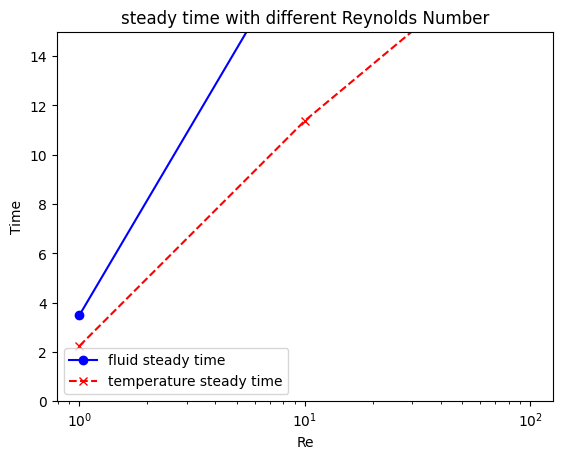

In [56]:
import matplotlib.pyplot as plt
import numpy as np

x = [1, 10, 100]
y1 = [3.49008710, 19, 35]
y2 = [2.23888118, 11.38214741, 19]
plt.semilogx(x, y1, label='fluid steady time', marker='o', linestyle='-', color='blue')
plt.semilogx(x, y2, label='temperature steady time', marker='x', linestyle='--', color='red')
plt.title('steady time with different Reynolds Number')
plt.xlabel('Re')
plt.ylabel('Time')
plt.legend()
plt.ylim(0, 15)
plt.show()


The code run for 15 seconds for each situation, we did not simulate the exact steady number for bigger Reynolds Number. But from this graph, we find that __with the Reynolds Number increased, the steady time for both field system and temperature system are all increase highly!__

And from the graphs for different Reynolds Number above, we can find that __the bigger the Reynolds Number is, the more complicated the system is. As the Reynolds number gets larger, three types of graphs becomes more and more irregular.__

Paying attention to the temperature image under each condition, we can also find that __as the Reynolds number increases, the high-temperature red areas in the image also increase, indicating that the increase in Reynolds number will promote the diffusion of thermal energy.__


## __Series 2 Prandtl Number__

## Occassion for Pr = 1:
First to decrease k to 1e-6 to make the Prandtl Number to 1

In [ ]:
u_input = 0.0001
v_input = 0.
Lx = 0.01
k = 1e-6
rho = 1000.
mu = 0.001
nu = mu / rho
print(cal(u_input, v_input, Lx, k, rho, mu, nu))
u, v, p, T = model(u_input, v_input, Lx, k, rho, mu, nu)
draw(u, v, p, T)

## Occassion for Pr = 10:
Decrease $ \rho $ to 100, to make Pr increase to 10

In [ ]:
u_input = 0.0001
v_input = 0.
Lx = 0.01
k = 1e-6
rho = 100.
mu = 0.001
nu = mu / rho
print(cal(u_input, v_input, Lx, k, rho, mu, nu))
u, v, p, T = model(u_input, v_input, Lx, k, rho, mu, nu)
draw(u, v, p, T)

## Occassion for Pr = 100(can not run to steady, it cost too much time):
Increase $ \mu $ to 0.01, to make Pr increase to 100

In [ ]:
u_input = 0.0001
v_input = 0.
Lx = 0.01
k = 1e-6
rho = 100.
mu = 0.01
nu = mu / rho
print(cal(u_input, v_input, Lx, k, rho, mu, nu))
u, v, p, T = model(u_input, v_input, Lx, k, rho, mu, nu)
draw(u, v, p, T)

## Occassion for Pr = 100:
Decrease $ k $ to 1e-7, to make Pr increase to 100

In [ ]:
u_input = 0.0001
v_input = 0.
Lx = 0.01
k = 1e-7
rho = 100.
mu = 0.001
nu = mu / rho
print(cal(u_input, v_input, Lx, k, rho, mu, nu))
u, v, p, T = model(u_input, v_input, Lx, k, rho, mu, nu)
draw(u, v, p, T)

### __IMPORTANT FOR SERIES 2__
In series 2, the Prandtl number is increased from 1 to 10 to 100.

In this series, we got four samples with Prandtl number of 1, 10, 100, 100. However, the third one cost too much time and can not be run to a steady status in 2 hours. This situation will not be considered with the other three together in this series. 

But for this unique case, we can summarize that __if we increase the value of $ \mu $, then the compute cost would increase__.

Then let's consider this series 2. First let simply focus on the Prandtl Number and the steady time:


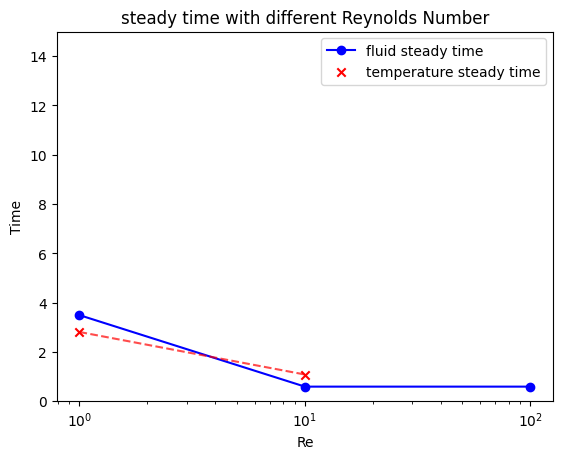

In [16]:
import matplotlib.pyplot as plt
import numpy as np

x = [1, 10, 100]
y1 = [3.49008710, 0.58817329, 0.58817329]
y2 = [2.80602297, 1.07968941]

x_y2 = x[:2]
y2 = y2[:2]

plt.semilogx(x, y1, label='fluid steady time', marker='o', linestyle='-', color='blue')
plt.scatter(x_y2, y2, label='temperature steady time', marker='x', color='red')

plt.plot(x_y2, y2, linestyle='--', color='red', alpha=0.7)

plt.title('steady time with different Reynolds Number')
plt.xlabel('Re')
plt.ylabel('Time')
plt.legend()
plt.ylim(0, 15)
plt.show()


From the figure above, we can figure out that with the Prandtl number increased, the time to reach steady state decreased. But there may be a limit. Because when the Prandtl number increase from 10 to 100, the the things is not always the same.

Focus on the graph 'Pressure driven problem - Temperature' for each sample, we can see that with the Prandtl number increase, overall, the temperature of the liquid shows a downward trend when reach steady state. 

Focus on the graph 'Pressure driven problem - pressure and velocity vectors' for each sample, we can see that with the Prandtl number increase, overall, the pressure decreased and the pressure at the bottom decreases most obviously. 

Focus on the graph 'Pressure driven problem - speed' for each sample, we can see that with the Prandtl number increase, overall, the speed of the liquid shows a upgrade trend when reach steady state and the speed in the middle increases most obviously. 